<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/01_convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolutional neural networks

The success of convolutions comes from their ability to learn spatial patterns, which
has made them the default method to use for any data resembling an image.

Specifically, deep learning has been most successful at imposing
structural priors. By how we design the network, we impart some knowledge about the
intrinsic nature or structure of the data. 

The most common types of structure encoded
into neural networks are spatial correlation (i.e., images) and sequential
relationships (e.g., weather changes from one day to the next).

Images, however, are structured. There is an order to the pixels. If you shuffled the
pixels around, you would fundamentally change the meaning of a picture.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn1.png?raw=1' width='600'/>

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from scipy.signal import convolve

import time

from idlmam import train_simple_network, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

In [4]:
def move_to(obj, device):
  """
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  """
  if hasattr(obj, "to"):
      return obj.to(device)
  elif isinstance(obj, list):
      return [move_to(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(move_to(list(obj), device))
  elif isinstance(obj, set):
      return set(move_to(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[move_to(key, device)] = move_to(value, device)
      return to_ret
  else:
      return obj

##Preparing dataset

Here, we will start exploring the ubiquitous MNIST dataset. 

It’s a collection of black-and-white images of the digits 0
through 9; each is 28 pixels wide and 28 pixels tall.

In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)

x_example, y_example = mnist_data_train[0]

In [6]:
type(x_example), type(y_example)

(PIL.Image.Image, int)

Now you will notice that the type of the data returned is not a tensor.

We need to use a transform to convert the images to tensors.

In [7]:
# simply specify the ToTensor transform, which converts image into a tensor
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
type(x_example), type(y_example)

(torch.Tensor, int)

In [8]:
print(x_example.shape)

torch.Size([1, 28, 28])


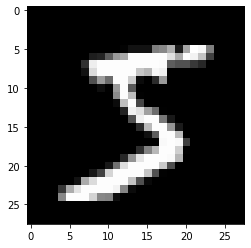

In [9]:
# visualize a tensor representation of an image
imshow(x_example[0, :], cmap="gray")

Let’s do a color version. If we stack three copies of the same digit on top of each other, we will have a tensor of shape `(3, 28, 28)`. 

Because the structure of the tensor has meaning,
this instantaneously makes it a color image by virtue of having three channels.

In [10]:
x_as_color = torch.stack([x_example[0, :], x_example[0, :], x_example[0, :]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


Now let’s visualize the color version.

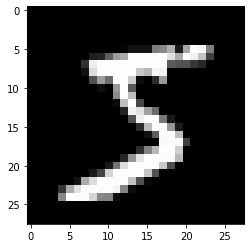

In [11]:
# need to permute the dimensions when using imshow
imshow(x_as_color.permute(1, 2, 0))

Why is this color image still black and white? 

Because the original image was black and
white. We have the same value copied in the red, green, and blue channels, which is
how you represent a black-and-white image in color. 

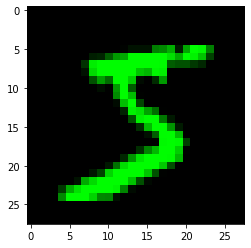

In [12]:
x_as_color = torch.stack([x_example[0, :], x_example[0, :], x_example[0, :]])

# If we zero out the red and blue channels, we get a green number
x_as_color[0, :] = 0  # No Red. We’re leaving Green alone.
x_as_color[2, :] = 0  # No Blue

imshow(x_as_color.permute(1, 2, 0))

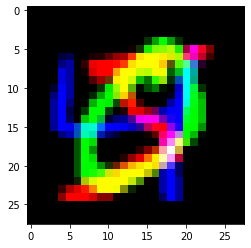

In [13]:
# let’s stack three different images together into one color image
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]  # Grabs 3 images
x1, x2, x3 = x1[0], x2[0], x3[0]   # drop the label

x_as_color = torch.stack([x1[0, :], x2[0, :], x3[0, :]], dim=0)
imshow(x_as_color.permute(1, 2, 0))

The order of the data has
meaning, and we can’t arbitrarily reorder things without potentially destroying the
structure and thus the data.

Let’s look at this more explicitly. 

What happens if we shuffle the data within a channel?
Does it have the same important structured meaning? 

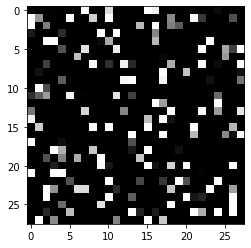

In [14]:
# Let’s look at the digit 5 one last time but randomly shuffle the values in the tensor
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)

imshow(x_shuffled[0, :], cmap="gray")

As you can see, this has completely changed the meaning of the image. 
Instead of being a 5, it’s . . . nothing, really.

**The locations of a value and its nearby values are intrinsically part
of that value’s meaning. The value of one pixel cannot be separated from its neighbors. This is the structural spatial prior we try to capture.**

##1D convolutions

To understand how a convolution works, let’s talk about a one-dimensional CNN first.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn2.png?raw=1' width='600'/>

For each output, you can see arrows
coming in for the spatially relevant inputs for that output.

Notice it is always the same three values
from the filter, applied to every position in the input.

In [15]:
filter = [1, 0, -1]
input = [1, 0, 2, -1, 1, 2]
output = []

# Slides the filter over the input
for i in range(len(input) - len(filter)):
  result = 0
  # Applies the filter at this location
  for j in range(len(filter)):
    result += input[i + j] * filter[j]
  output.append(result)
print(output)

[-1, 1, 1]


In effect, we are sliding the filter across every location in the input, computing a value at
each location, and storing it in the output. That’s what a convolution is. 

The size of the output shrinks because we run out of values at the edges of the input.

##2D convolutions

As we increase the number of dimensions $r$ in our tensor, the idea of convolutions and
how they work stays the same: we slide a filter around the input, multiply the values in
the filter with each area of the image, and then take the sum.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn3.png?raw=1' width='600'/>

Again, the 2D output results from multiplying the filter values (pairwise) at each location
and summing them all.

In [16]:
filter = [
  [0, 1, 0],
  [0, 1, 0],
  [0, 1, 0]        
]
input = [
  [0, 0, 1, 1, 0, 0],
  [0, 1, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 1, 1, 1, 1, 1]      
]

height, width = len(input), len(input[0])
output = []

# Slides the filter over the rows
for i in range(height - len(filter)):
  row_out = []
  # Slides the filter over the columns
  for j in range(width - len(filter)):
    result = 0
    # Applies the filter at this location
    for k_i in range(len(filter)):
      for k_j in range(len(filter)):
        result += input[i + k_i][j + k_j] * filter[k_i][k_j]
    row_out.append(result)
  output.append(row_out)

print(output)

[[1, 1, 3], [1, 0, 3], [0, 0, 3]]


##Image processing

Let’s again look at a specific image of the digit 4 from MNIST.

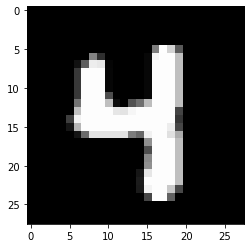

In [18]:
img_index = 58
img = mnist_data_train[img_index][0][0, :]
plt.imshow(img, vmin=0, vmax=1, cmap="gray")

One common computer vision operation is to blur an image. Blurring involves taking
a local average pixel value and replacing every pixel with the average of its neighbors.

This can be useful to wash out small noisy artifacts or soften a sharp edge.

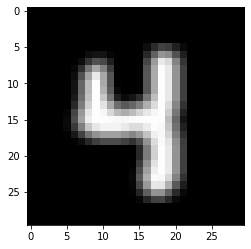

In [19]:
blur_filter = np.asarray([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]                    
]) / 9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap="gray")
plt.show()

An especially common application of convolutions is to perform edge detection.

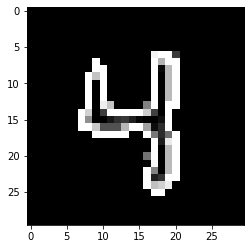

In [20]:
# find edges by focusing on the difference between a pixel and its neighbors
edge_filter = np.asarray([
   [-1, -1, -1], 
   [-1, 8, -1],
   [-1, -1, -1],                      
])

edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

If we constrain ourselves to a `3 x 3` kernel, it is easiest to find horizontal or vertical edges. 

Let’s create one for horizontal edges by making the kernel values change signs across the horizontal of the filter.

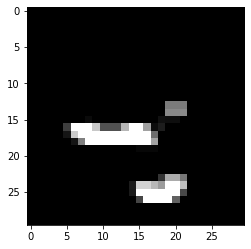

In [21]:
# look for only horizontal edges
h_edge_filter = np.asarray([
   [-1, -1, -1], 
   [0, 0, 0],
   [1, 1, 1],                      
])

h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

Let’s create one for vertical edges by making the kernel values change signs across the vertical of the filter.

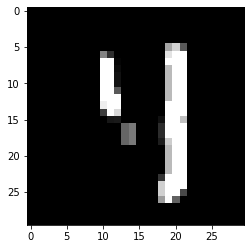

In [22]:
# look for only vertical edges
v_edge_filter = np.asarray([
   [-1, 0, 1], 
   [-1, 0, 1],
   [-1, 0, 1],                      
])

v_edge_img = convolve(img, v_edge_filter)
plt.imshow(v_edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

##First naive CNN